In [4]:
from src.base_models import *
from src.dataset_lib import *
from src.ode_solvers import *
from src.comp_models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
GaussianMix = GaussianMixture.symmetric_2D(4,std = 1)

rec1 = Rectangle(device=device, coords= [(-5.0,5.0),(-10,10)])

dataset = UnionSample([GaussianMix, rec1])

gaussian_path = GaussianConditionalProbabilityPath(p_data=dataset, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = EmbeddedBasicMLP(input_dim=2, hidden_dims=[64,64,64,64], conditional=True, embedding_dim=40, num_conditions=6)

trainer = RecCenterGuidanceTrainer(path=gaussian_path, model=model1,  num_conditions=6, p_uncond=0.1,model_type="FM", rectangle_boundaries=[[(-5.0,5.0),(-10,10)]], centers=[torch.Tensor([10.0,0.0]), torch.Tensor([0.0,-10.0]), torch.Tensor([0.0,10.0]), torch.Tensor([-10.0,0.0])])

trainer.train_loop(num_epochs=5000, device=device, lr=1e-3, n= 1000)

In Epoch 0 we have a loss of 64.14854431152344
In Epoch 1000 we have a loss of 6.1913299560546875
In Epoch 2000 we have a loss of 6.684636116027832
In Epoch 3000 we have a loss of 6.106067657470703
In Epoch 4000 we have a loss of 6.468574523925781


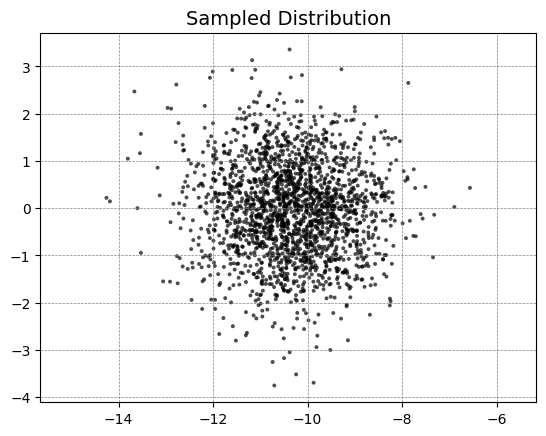

In [17]:
ode = GuidedVectorField(model1, guidance_scale=1, null_index=5)
solver = EulerODESolver(ode)
sampler = Sampler(solver)

steps = torch.linspace(0.01, 1, 2000).view(1, -1, 1).expand(2000, -1, 1).to(device)
gaussian_samples = gaussian_path.p_init.sample(2000)

condition_index = 3
y_index = torch.full((gaussian_samples.shape[0],), fill_value=condition_index, dtype=torch.long, device=device)

final_samples = sampler.sample_without_traj(gaussian_samples, steps, y_index = y_index)

plot_samples(final_samples)
plt.show()

Lets look at the diffusion case for guidance

In [ ]:
GaussianMix = GaussianMixture.symmetric_2D(4,std = 1)

rec1 = Rectangle(device=device, coords= [(-5.0,5.0),(-10,10)])

dataset = UnionSample([GaussianMix, rec1])

gaussian_path = GaussianConditionalProbabilityPath(p_data=dataset, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = EmbeddedBasicMLP(input_dim=2, hidden_dims=[64,64,64,64], conditional=True, embedding_dim=40, num_conditions=6)

trainer = RecCenterGuidanceTrainer(path=gaussian_path, model=model1, num_conditions=6, p_uncond=0.1,model_type="Diffusion",rectangle_boundaries=[[(-5.0,5.0),(-10,10)]], centers=[torch.Tensor([10.0,0.0]), torch.Tensor([0.0,-10.0]), torch.Tensor([0.0,10.0]), torch.Tensor([-10.0,0.0])])

trainer.train_loop(num_epochs=5000, device=device, lr=1e-3, n= 1000)

In Epoch 0 we have a loss of 8.745031356811523
In Epoch 1000 we have a loss of 5.660681247711182
In Epoch 2000 we have a loss of 6.6093525886535645
In Epoch 3000 we have a loss of 4.830595016479492
In Epoch 4000 we have a loss of 7.080079555511475


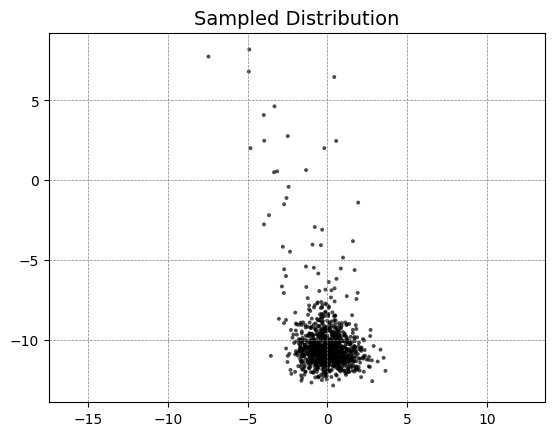

In [ ]:
sde = ProductGuidanceLangevin([model1, model1], alpha=LinearAlpha(), beta=SquareRootBeta(), sigma=1.0, guidance_scales= [1.0, 1.0], null_index=trainer.null_index)
sdesolver = EulerSDESolver(sde)
sdesampler = Sampler(sdesolver)

steps = torch.linspace(0.05, 1, 1000).view(1, -1, 1).expand(1000, -1, 1).to(device)
gaussian_samples = gaussian_path.p_init.sample(1000)



condition_index1 = 4
y_index1 = torch.full((gaussian_samples.shape[0],), fill_value=condition_index1, dtype=torch.long, device=device)

condition_index2 = 1
y_index2 = torch.full((gaussian_samples.shape[0],), fill_value=condition_index2, dtype=torch.long, device=device)

indicies = [y_index1, y_index2]

final_samples = sdesampler.sample_with_traj(gaussian_samples, steps, y_index = indicies)

plot_samples(final_samples[-1])
plt.show()

In [ ]:
GaussianMix = GaussianMixture.symmetric_2D(4,std = 1)

rec1 = Rectangle(device=device, coords= [(-5.0,5.0),(-10,10)])

dataset = UnionLogSample([GaussianMix, rec1])

gaussian_path = GaussianConditionalProbabilityPath(p_data=dataset, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = EmbeddedBasicMLP(input_dim=2, hidden_dims=[64,64,64,64], conditional=True, embedding_dim=40, num_conditions=3)

centers_list = [torch.Tensor([10.0,0.0]), torch.Tensor([0.0,-10.0]), torch.Tensor([0.0,10.0]), torch.Tensor([-10.0,0.0])]

trainer = RecGMGuidanceTrainer(path=gaussian_path, 
                               model=model1, 
                               num_conditions=3, 
                               p_uncond=0.2,
                               model_type="Diffusion",
                               rectangle_boundaries=[[(-5.0,5.0),(-10,10)]], 
                               centers=[centers_list]) 

trainer.train_loop(num_epochs=10000, device=device, lr=1e-3, n= 2000)

In Epoch 0 we have a loss of 15.416433334350586
In Epoch 1000 we have a loss of 5.466329574584961
In Epoch 2000 we have a loss of 6.273592948913574
In Epoch 3000 we have a loss of 11.462509155273438
In Epoch 4000 we have a loss of 23.086130142211914
In Epoch 5000 we have a loss of 6.2762041091918945
In Epoch 6000 we have a loss of 7.543135166168213
In Epoch 7000 we have a loss of 8.370684623718262
In Epoch 8000 we have a loss of 12.632026672363281
In Epoch 9000 we have a loss of 8.151185035705566


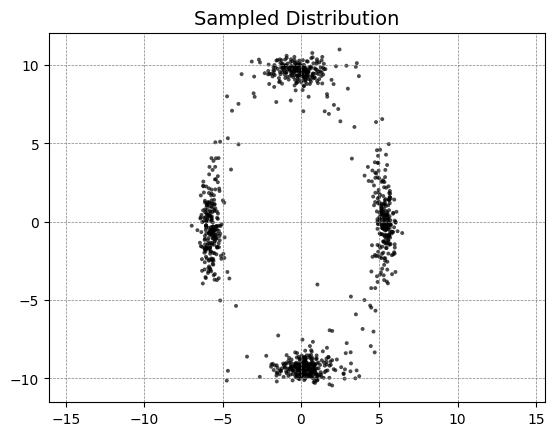

In [11]:
sde = ProductGuidanceLangevin([model1, model1], alpha=LinearAlpha(), beta=SquareRootBeta(), sigma=1.0, guidance_scales= [1.0, 1.0], null_index=trainer.null_index)
sdesolver = EulerSDESolver(sde)
sdesampler = Sampler(sdesolver)

steps = torch.linspace(0.05, 1, 1000).view(1, -1, 1).expand(1000, -1, 1).to(device)
gaussian_samples = gaussian_path.p_init.sample(1000)

condition_index1 = 0
y_index1 = torch.full((gaussian_samples.shape[0],), fill_value=condition_index1, dtype=torch.long, device=device)

condition_index2 = 1
y_index2 = torch.full((gaussian_samples.shape[0],), fill_value=condition_index2, dtype=torch.long, device=device)

indicies = [y_index1, y_index2]

final_samples = sdesampler.sample_with_traj(gaussian_samples, steps, y_index = indicies)

plot_samples(final_samples[-1])
plt.show()